# Sudoku solver - Convolutional Neural Network

### Imports

In [3]:
# Library imports
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [4]:
# Function imports
from sklearn.model_selection import train_test_split
from utils.normalization import normalize, denormalize
from keras.layers import Activation
from keras.layers import Conv2D, BatchNormalization, Dense, Flatten, Reshape

### Data loading

In [5]:
# Load the data
data: pd.DataFrame = pd.read_csv('sudoku.csv')
data.head()

,quizzes,solutions
0,0043002090050090010700600430060020871900074000...,8643712593258497619712658434361925871986574322...
1,0401000501070039605200080000000000170009068008...,3461792581875239645296483719658324174729168358...
2,6001203840084590720000060050002640300700800069...,6951273841384596727248369158512647392739815469...
3,4972000001004000050000160986203000403009000000...,4972583161864397252537164986293815473759641828...
4,0059103080094030600275001000300002010008200070...,4659123781894735623275681497386452919548216372...


### Preprocessing

#### Numpy conversion

In [6]:
# Split data into inputs and outputs (Respectively X an y)
X, y = data.loc[:, 'quizzes'], data.loc[:, 'solutions']

# Convert the data to numpy arrays
X = np.array(X)
y = np.array(y)

#### Reshape

In [7]:
# Reshape input and output data
split_char = lambda x: np.array(list(x))

X = np.array(list(map(split_char, X)), dtype=np.int8).reshape((-1, 9, 9, 1))
y = np.array(list(map(split_char, y)), dtype=np.int8).reshape((-1, 81, 1))

#### Normalization

In [8]:
# Input
X = normalize(X)
# Output
y -= normalize(y, is_test=True)

In [22]:
# Split data into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Model architecture

In [31]:
def build_model() -> keras.models.Sequential:
    """
    Builds the model for the sudoku solver.
    Returns:
        model: The compiled model for the sudoku solver.
    """

    model = keras.models.Sequential()

    model.add(keras.layers.Input(shape=(9, 9, 1)))

    for _ in range(2):
        model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
        model.add(BatchNormalization())

    model.add(Conv2D(9, kernel_size=(1,1), activation='relu', padding='same'))

    model.add(Flatten())
 
    model.add(Dense(81 * 9))
    model.add(Reshape((-1, 9)))
    model.add(Activation('softmax'))

    adam: keras.optimizers.Adam = keras.optimizers.Adam(lr= 1e-4, beta_1=0.9, beta_2=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

### Training

In [34]:
model: keras.models.Sequential = build_model()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=2)

/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/2
    1/10000 [..............................] - ETA: 1:03:21 - loss: 2.4512 - accuracy: 0.1281

2023-03-22 21:09:01.794426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 9999/10000 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 0.9989

2023-03-22 21:13:49.355216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10000/10000 [==============================] - 315s 31ms/step - loss: 0.0030 - accuracy: 0.9989 - val_loss: 1.5821e-12 - val_accuracy: 1.0000
Epoch 2/2
10000/10000 [==============================] - 314s 31ms/step - loss: 8.1864e-13 - accuracy: 1.0000 - val_loss: 3.3114e-13 - val_accuracy: 1.0000


### Testing

In [36]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=64)

print(f'Test loss precision: {test_loss}')
print(f'Test precision: {test_acc * 100:.2f}%')

3125/3125 [==============================] - 39s 13ms/step - loss: 7.0643e-13 - accuracy: 1.0000
Test loss precision: 7.064254237999779e-13
Test precision: 100.00%


### Results

#### Convert history to Pandas DataFrame

In [39]:
history_df = pd.DataFrame(history.history)

#### Results plotting function

In [41]:
def results_analysis(history: pd.DataFrame, analysed_parameter: str) -> None:
    """
    Plots the results of the model.
    Args:
        history (pd.DataFrame): The history of the model.
    """
    history_data = None
    history_val_data = None
    if analysed_parameter == 'Accuracy':
        history_data = history.accuracy
        history_val_data = history.val_accuracy
    else:
        history_data = history.loss
        history_val_data = history.val_loss

    plt.plot(history_data, label=f'Training {analysed_parameter.lower()}')
    plt.plot(history_val_data, label=f'Validation {analysed_parameter.lower()}')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(f'{analysed_parameter}')
    plt.show()

#### Validation

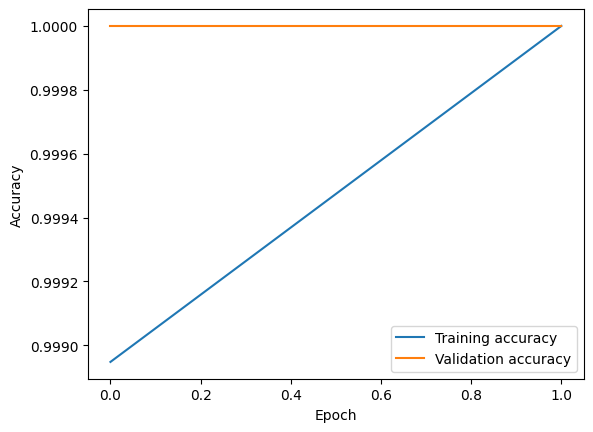

In [42]:
results_analysis(history_df, 'Accuracy')

#### Loss

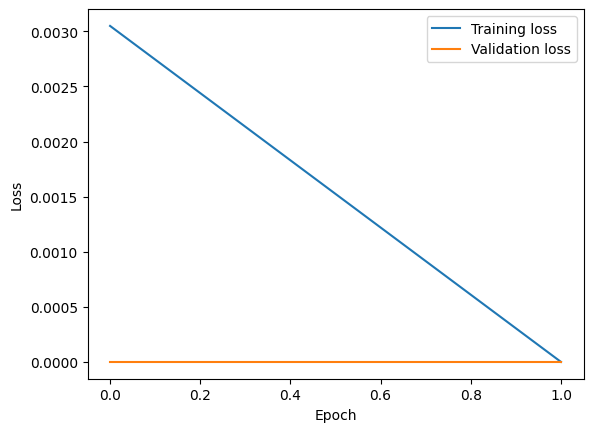

In [43]:
results_analysis(history_df, 'Loss')

### Model export

In [44]:
model.save('./model/solver.h5')